In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit
from convokit import TextParser, TensorDecomposer, Corpus, download
import pandas as pd
import numpy as np

In [3]:
corpus = Corpus(filename=download("reddit-coarse-discourse-corpus"))

Dataset already exists at /Users/calebchiam/.convokit/downloads/reddit-coarse-discourse-corpus


In [4]:
corpus.print_summary_stats()

Number of Speakers: 63573
Number of Utterances: 115827
Number of Conversations: 9483


In [5]:
full_convos = {c.id for c in corpus.iter_conversations() if c.check_integrity(verbose=False)}

In [6]:
corpus.filter_conversations_by(lambda convo: convo.id in full_convos)

In [7]:
corpus.print_summary_stats()

Number of Speakers: 62416
Number of Utterances: 113364
Number of Conversations: 9357


In [8]:
for utt in corpus.iter_utterances():
    utt.timestamp = 0

In [9]:
import random

In [10]:
longest_path_ids = []
for convo in corpus.iter_conversations():
    longest_path = random.choice(convo.get_longest_paths())
    convo.meta['longest_path'] = len(longest_path)
    longest_path_ids.extend([utt.id for utt in longest_path])

In [11]:
longest_path_ids = set(longest_path_ids)

In [12]:
corpus = corpus.filter_utterances_by(lambda utt: utt.id in longest_path_ids)

In [13]:
convo_df = corpus.get_conversations_dataframe()

In [14]:
import seaborn as sns

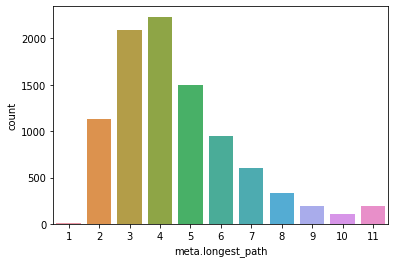

In [15]:
sns.countplot(convo_df['meta.longest_path'])

In [16]:
annotation_types = set()
for utt in corpus.iter_utterances():
    for t in utt.meta['annotation-types']:
        annotation_types.add(t)

In [17]:
annotation_types = sorted(list(annotation_types))
annotation_types

['agreement',
 'announcement',
 'answer',
 'appreciation',
 'disagreement',
 'elaboration',
 'humor',
 'negativereaction',
 'other',
 'question']

In [18]:
for utt in corpus.iter_utterances():
    utt.meta['annot-dict'] = {k: 0 for k in annotation_types}
    for t in annotation_types:
        utt.meta[t] = 0
    for t in utt.meta['annotation-types']:
        utt.meta['annot-dict'][t] = 1
        utt.meta[t] = 1

In [19]:
LENGTH = 8
min_length = lambda utt: utt.meta['valid']

In [20]:
for convo in corpus.iter_conversations():
    utts = convo.get_chronological_utterance_list()
    for utt_idx in range(len(utts) - LENGTH):
        subset = utts[utt_idx: utt_idx + LENGTH]
        start_utt = utts[utt_idx]
        for idx, utt in enumerate(subset):
            start_utt.meta['annot-dict-{}'.format(idx+1)] = utt.meta['annot-dict']
        start_utt.meta['valid'] = True

In [21]:
for utt in corpus.iter_utterances():
    if 'valid' not in utt.meta:
        utt.meta['valid'] = False

In [22]:
td = TensorDecomposer(feature_set=['annot-dict-{}'.format(idx) for idx in range(1, 8+1)], 
                      obj_type="utterance", tensor_func='tensortools-ncp-bcd', rank=20)

In [23]:
td.fit(corpus, selector=min_length)

Constructing tensor...Done.
Decomposing tensor...NCP_BCD: iteration 1, objective 0.8442137666000282, improvement inf.
NCP_BCD: iteration 2, objective 0.8247366002751706, improvement 0.01947716632485763.
NCP_BCD: iteration 3, objective 0.8048519373078749, improvement 0.01988466296729574.
NCP_BCD: iteration 4, objective 0.782825257241573, improvement 0.022026680066301818.
NCP_BCD: iteration 5, objective 0.762431979124606, improvement 0.020393278116967006.
NCP_BCD: iteration 6, objective 0.7444934117174844, improvement 0.01793856740712163.
NCP_BCD: iteration 7, objective 0.7286655696358643, improvement 0.015827842081620136.
NCP_BCD: iteration 8, objective 0.7144216774779807, improvement 0.014243892157883575.
NCP_BCD: iteration 9, objective 0.7021760766394637, improvement 0.012245600838517001.
NCP_BCD: iteration 10, objective 0.6915423352495436, improvement 0.010633741389920126.
NCP_BCD: iteration 11, objective 0.6814348428819961, improvement 0.010107492367547488.
NCP_BCD: iteration 12, ob

Directory already exists. Exiting summarize()


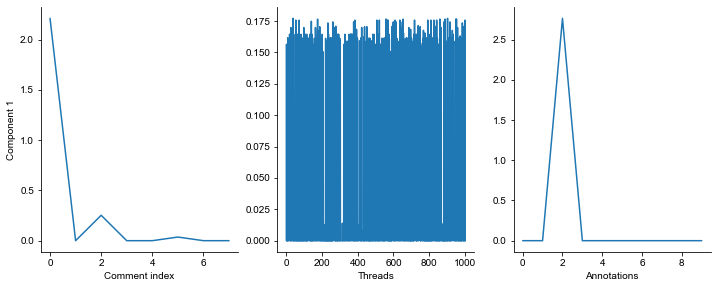

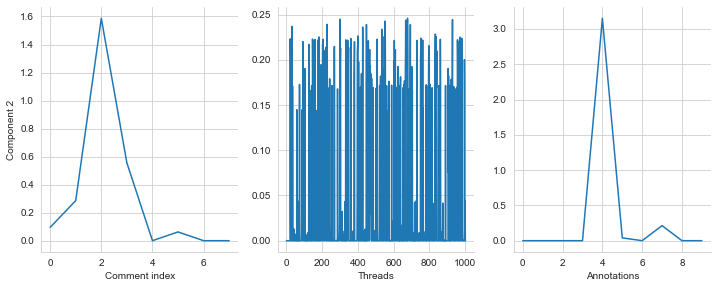

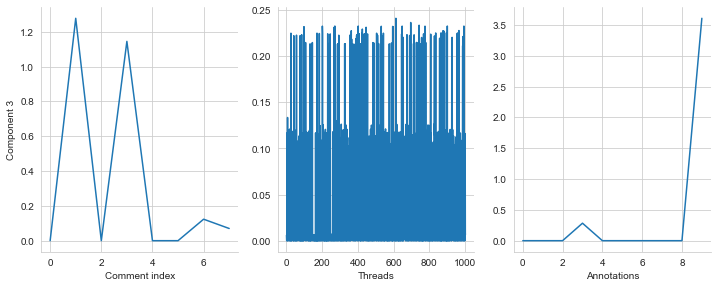

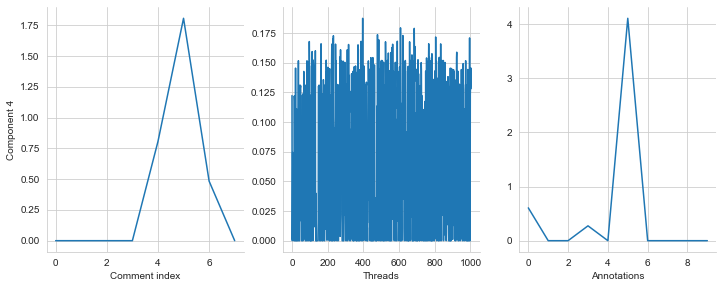

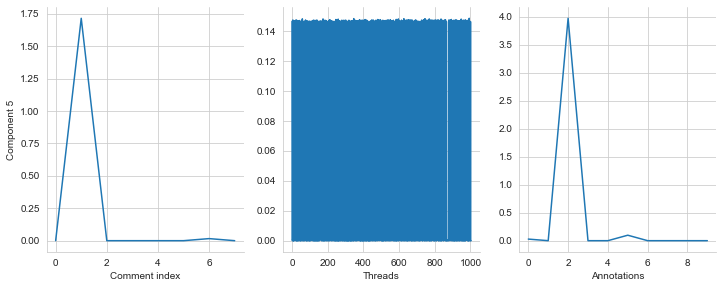

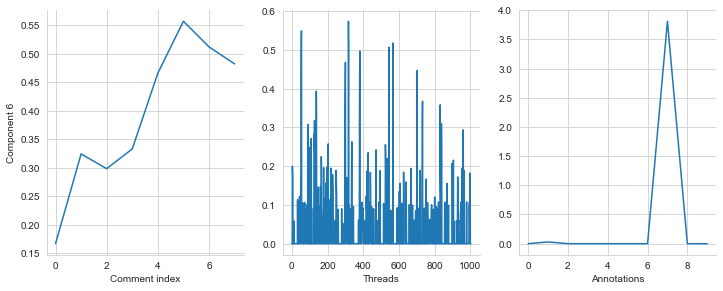

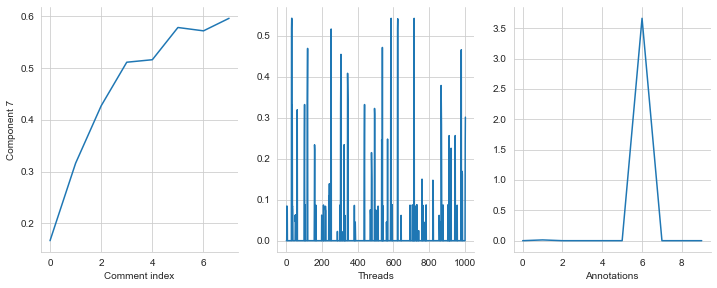

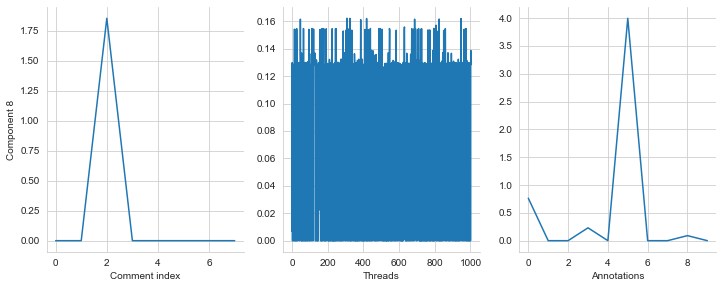

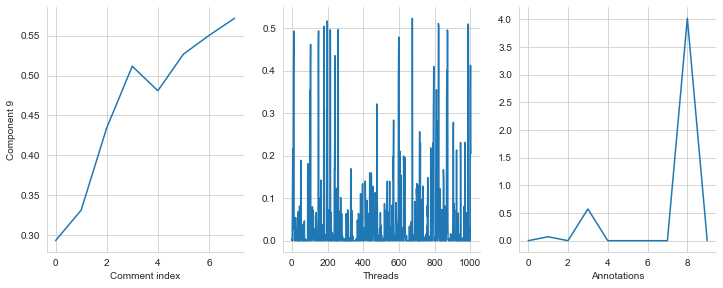

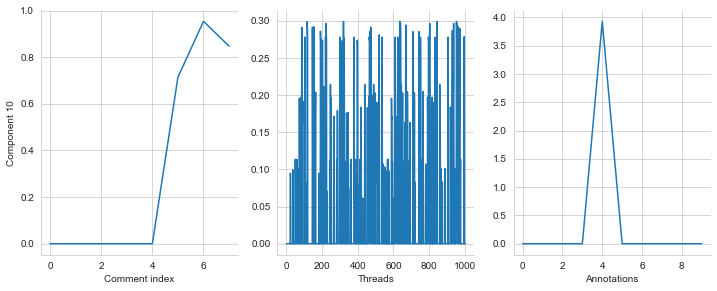

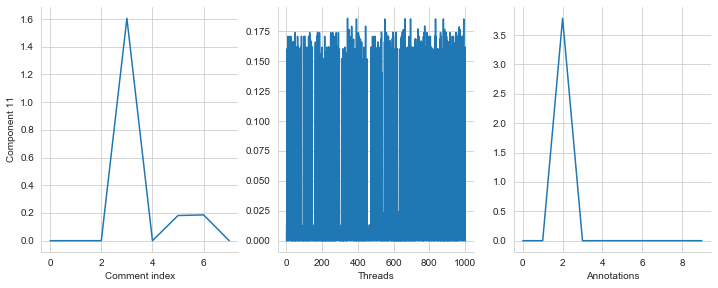

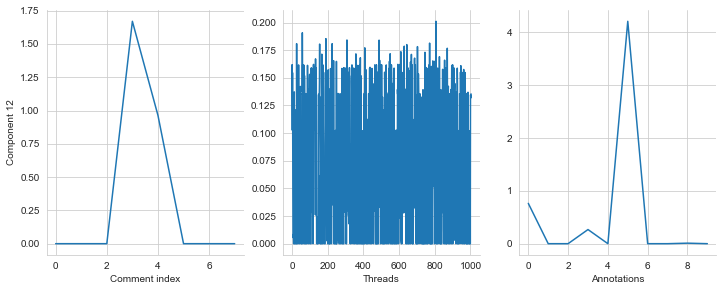

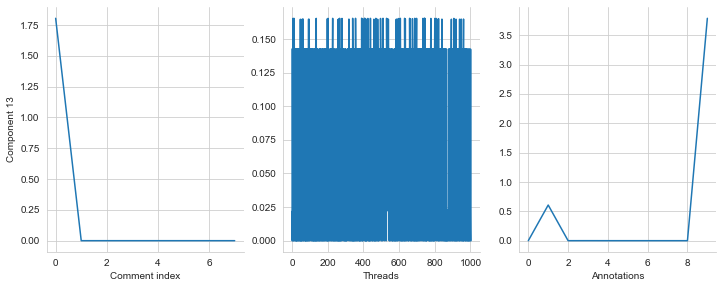

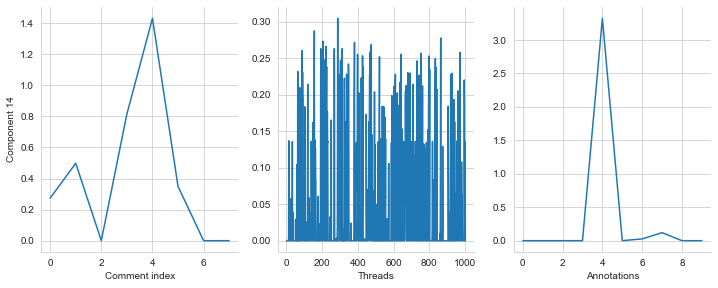

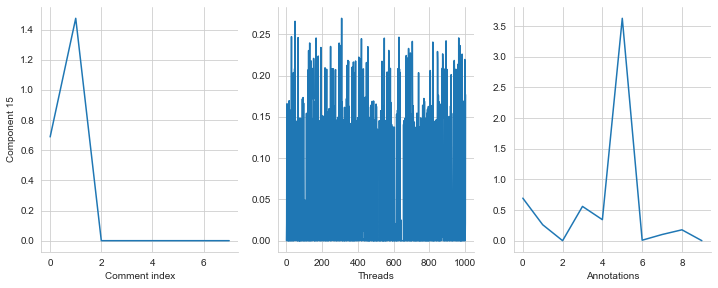

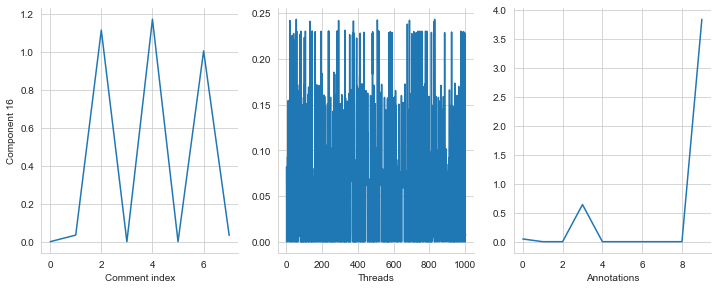

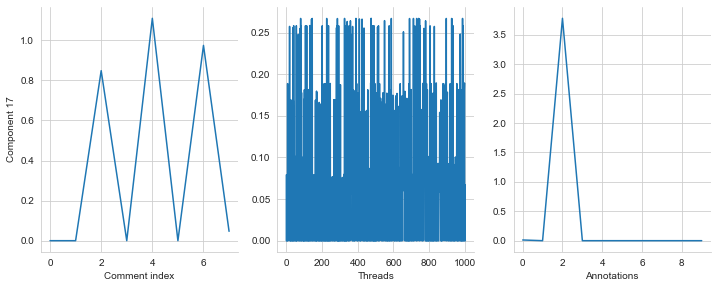

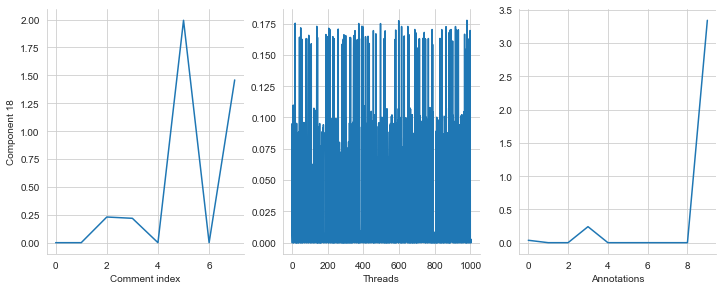

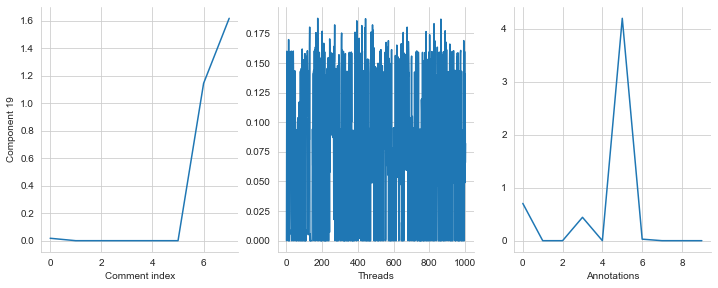

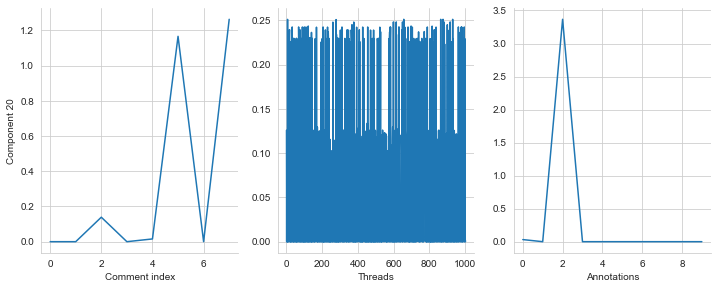

In [24]:
td.summarize(corpus, axis_names=['Comment index', 'Threads', 'Annotations'], 
             output_dir='convokit/tensor_decomposer/reports/coarse-discourse', 
             report_title='Coarse discourse', 
             liwc=True)

### Some breakdowns

In [25]:
td.factors[1].shape

(1004, 20)

In [26]:
thread_df = pd.DataFrame(td.factors[1].T)

In [27]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

def std_scale_df(df):
    d = dict()
    for i in range(df.shape[0]):
        d[i+1] = std_scaler.fit_transform(np.array(df.iloc[i]).reshape(-1, 1)).flatten()
    return pd.DataFrame.from_dict(d).T

In [28]:
def get_component_decomposition_nonnegative(V):
    feat_df = pd.DataFrame(V, index=list(range(1, V.shape[0]+1)), columns=list(range(1, V.shape[1]+1))).T
    retval = dict()
    for i in range(feat_df.shape[0]):
        s = sorted(list(feat_df.iloc[i].items()), key=lambda x: x[1], reverse=True)
        pos = [x[0] for x in s if x[1] >= 1]
        retval[i+1] = {'pos': pos}
    return retval

In [29]:
decomposed = get_component_decomposition_nonnegative(std_scale_df(thread_df).T)

In [30]:
print(decomposed[2]['pos'])

[678, 300, 930, 668, 553, 228, 448, 694, 32, 427, 534, 834, 400, 539, 839, 182, 972, 753, 982, 360, 21, 146, 508, 205, 862, 160, 958, 332, 176, 204, 763, 343, 732, 604, 154, 459, 458, 961, 92, 381, 202, 125, 203, 399, 798, 268, 269, 221, 348, 303, 752, 398, 466, 797, 610, 267, 217, 842, 302, 339, 833, 347, 397, 535, 449, 667, 220, 380, 554, 800, 679, 997, 605, 983, 22, 602, 751, 404, 177, 126, 344, 959, 193, 469, 625, 702, 552, 537, 906, 103, 301, 609, 796, 465, 841, 338, 346, 666, 299, 693, 91, 447, 219, 929, 832, 472, 420, 908, 379, 541, 527, 639, 477, 242, 147, 923, 661, 209, 574, 454, 606, 222, 509, 803, 73, 223, 461, 658, 783, 229, 589, 551, 700, 914, 522, 924, 785, 891, 638, 853, 141, 255, 561, 34, 634, 544, 937, 415, 334, 955, 616, 654, 161, 486, 815, 816, 233, 840, 502, 683, 286, 946, 206, 705, 970, 941, 136, 998, 96, 155, 470, 863, 962, 935, 191, 765, 981, 467, 474, 58, 87, 572, 164]


In [31]:
for idx, utt in enumerate(corpus.iter_utterances(min_length)):
    if idx == 361:
        print(utt.id)
        break

t3_2sqie0


In [32]:
corpus.get_conversation('t3_2sqie0').print_conversation_structure(lambda utt: str(utt.meta['annotation-types']))

['question', 'question', 'question']
    ['answer', 'answer', 'answer']
        ['question', 'question', 'question']
            ['answer', 'answer', 'question']
                ['elaboration', 'elaboration', 'answer']
                    ['question', 'question', 'answer']
                        ['question', 'question', 'question']
                            ['answer', 'answer', 'answer']
                                ['elaboration', 'question', 'disagreement']
                                    ['elaboration', 'answer', 'elaboration']
                                        ['elaboration', 'question', 'elaboration']


In [33]:
td.factors[1][361]

array([0.        , 0.        , 0.09796436, 0.03492774, 0.1461803 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.15640195, 0.05155274, 0.14255515, 0.        , 0.        ,
       0.13621071, 0.08128973, 0.10322528, 0.        , 0.2256319 ])

In [34]:
np.array(std_scale_df(pd.DataFrame(td.factors[1]).T).T.iloc[361])

array([-0.60304452, -0.51604906,  0.52837936, -0.5392167 ,  1.07479405,
       -0.49128087, -0.28968867, -0.9897241 , -0.44523293, -0.58335538,
        1.39231715, -0.34200388,  0.90563559, -0.55324825, -0.79694081,
        1.03237711,  0.18120626,  1.14739516, -1.20909905,  1.85374147])

### TCA on Concat

In [35]:
concat_all = {}
for utt_idx, utt in enumerate(corpus.iter_utterances(selector=min_length)):
    concat = {}
    for idx in range(1, 8+1):
        for k, v in utt.meta['annot-dict-{}'.format(idx)].items():
            concat[k+str(idx)] = v
    concat_all[utt_idx] = concat

In [36]:
len(concat_all)

1004

In [37]:
# hack to make one convo hold the concatenated data
special_convo = corpus.random_conversation()

In [38]:
special_convo.meta['special'] = True
for k, v in concat_all.items():
    special_convo.meta['concat_{}'.format(k)] = v

In [39]:
td_concat = TensorDecomposer(feature_set=['concat_{}'.format(idx) for idx in range(1004)], 
                      obj_type="conversation", tensor_func='tensortools-ncp-bcd', rank=20)

In [40]:
td_concat.fit(corpus, selector=lambda convo: convo.meta.get('special', False) == True)

Constructing tensor...Done.
Decomposing tensor...NCP_BCD: iteration 1, objective 0.843494425997297, improvement inf.
NCP_BCD: iteration 2, objective 0.8337190021080925, improvement 0.009775423889204493.
NCP_BCD: iteration 3, objective 0.8288600549190278, improvement 0.004858947189064655.
NCP_BCD: iteration 4, objective 0.8206635842803857, improvement 0.00819647063864215.
NCP_BCD: iteration 5, objective 0.8045022312299819, improvement 0.01616135305040378.
NCP_BCD: iteration 6, objective 0.7766277070350445, improvement 0.02787452419493741.
NCP_BCD: iteration 7, objective 0.7449638774228522, improvement 0.031663829612192274.
NCP_BCD: iteration 8, objective 0.7199645252593903, improvement 0.02499935216346194.
NCP_BCD: iteration 9, objective 0.7006872084129586, improvement 0.019277316846431636.
NCP_BCD: iteration 10, objective 0.6844118718597074, improvement 0.016275336553251196.
NCP_BCD: iteration 11, objective 0.6705910777225835, improvement 0.013820794137123893.
NCP_BCD: iteration 12, ob

NCP_BCD: iteration 112, objective 0.50364829038054, improvement 1.0623969431966529e-05.
NCP_BCD: iteration 113, objective 0.5036415768865974, improvement 6.713493942656079e-06.
Converged after 113 iterations, 0.8319887990000012 seconds. Objective: 0.5036415768865974.
Done.


Directory already exists. Exiting summarize()


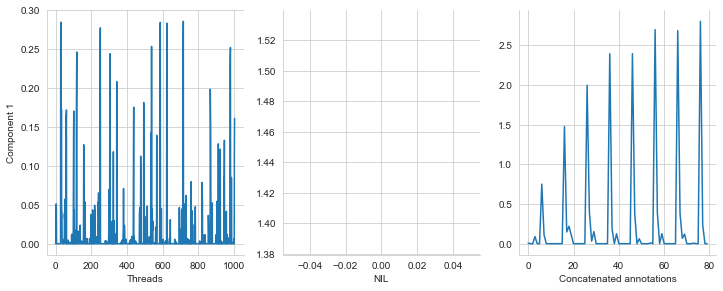

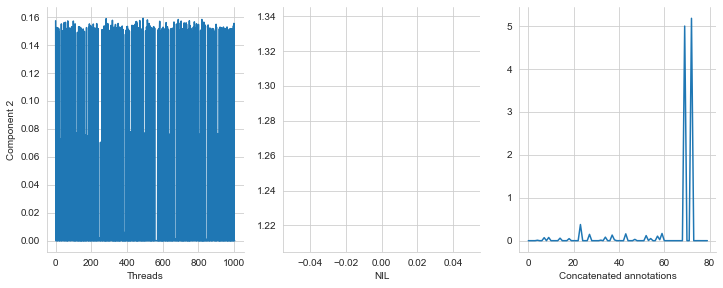

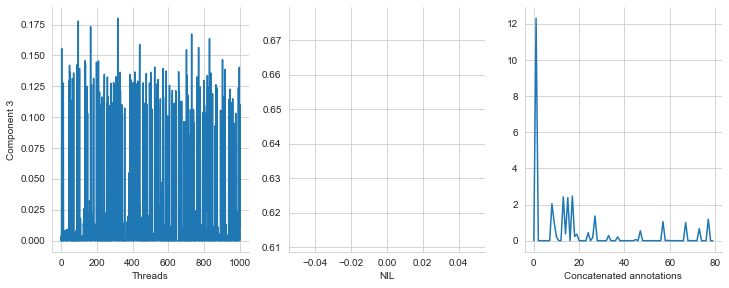

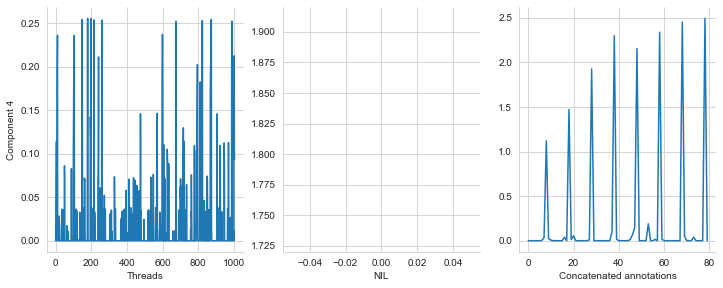

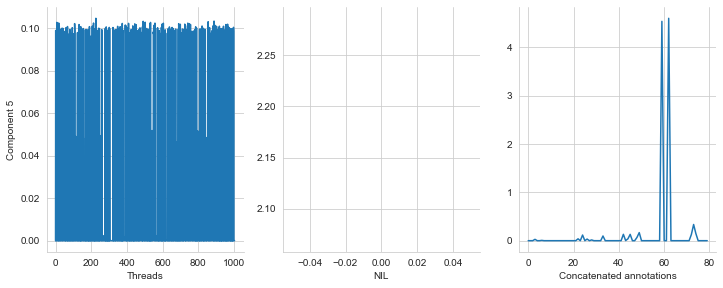

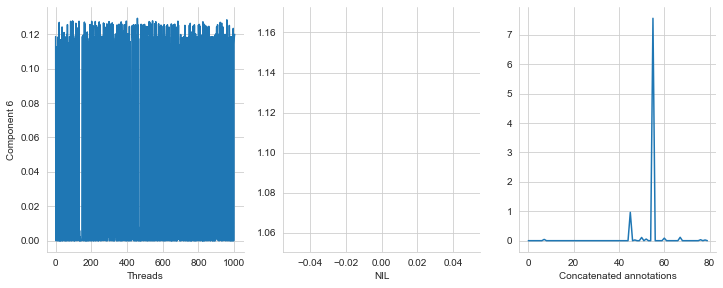

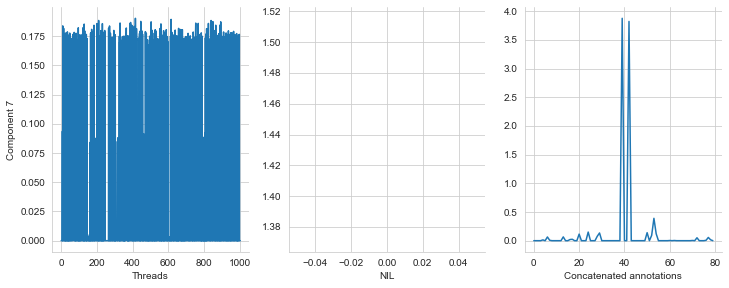

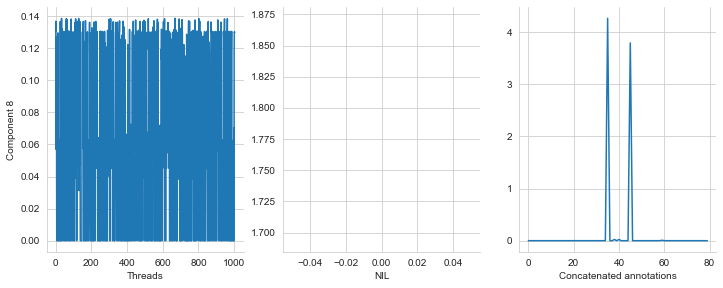

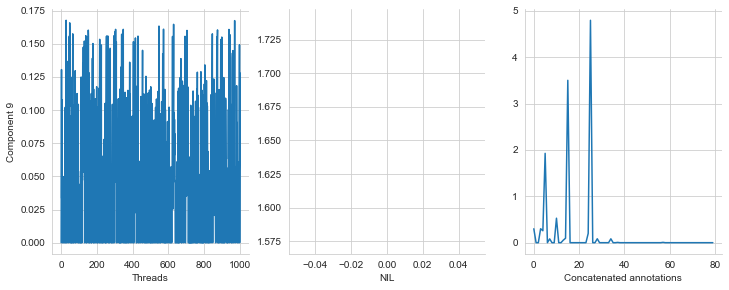

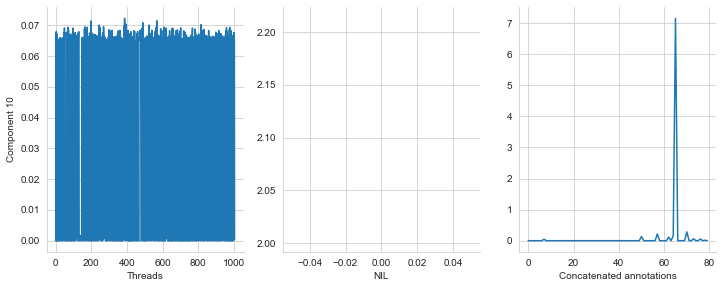

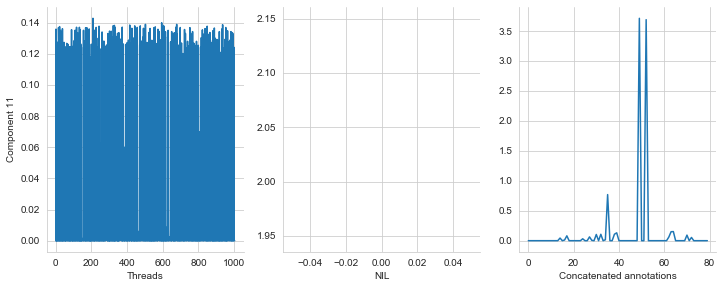

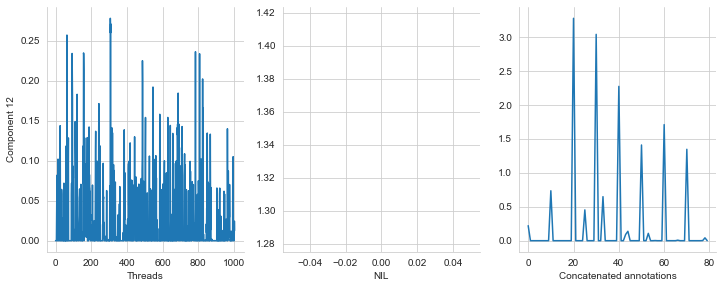

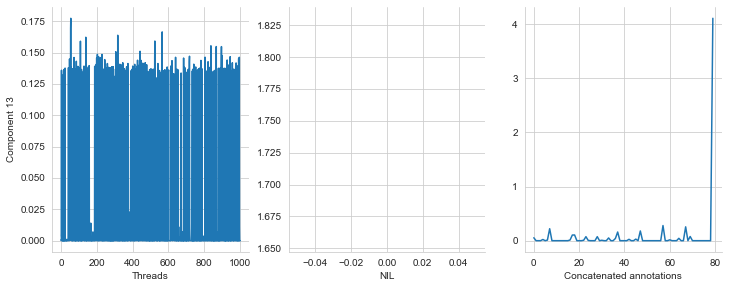

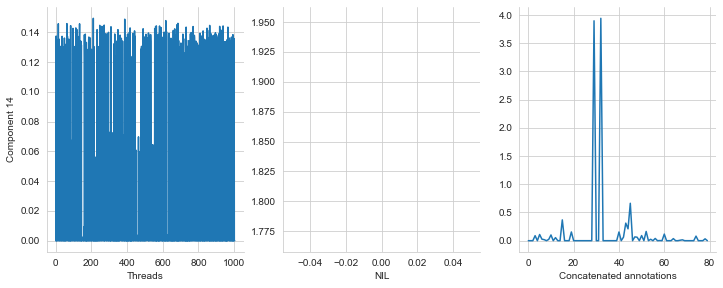

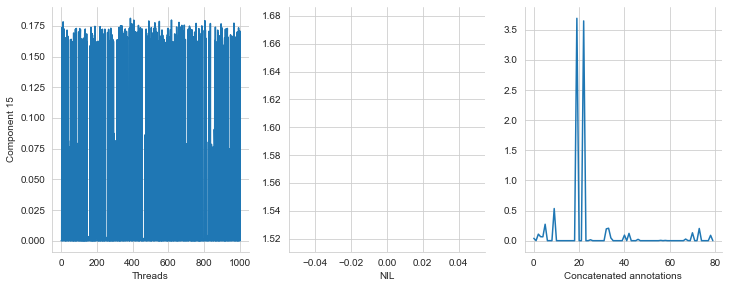

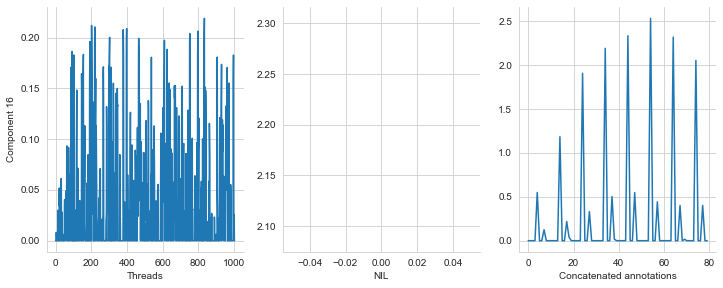

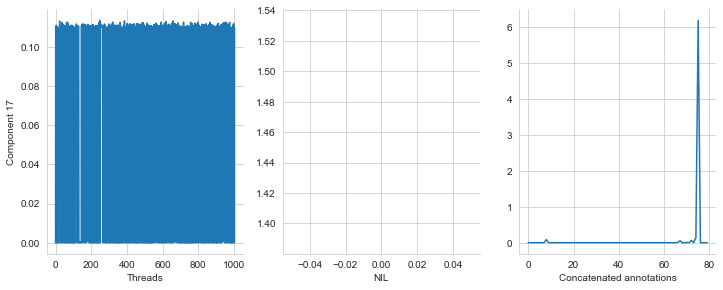

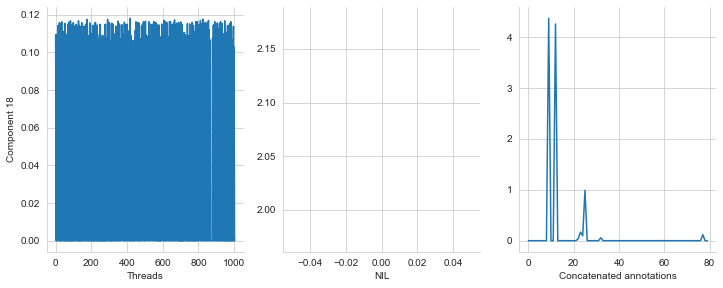

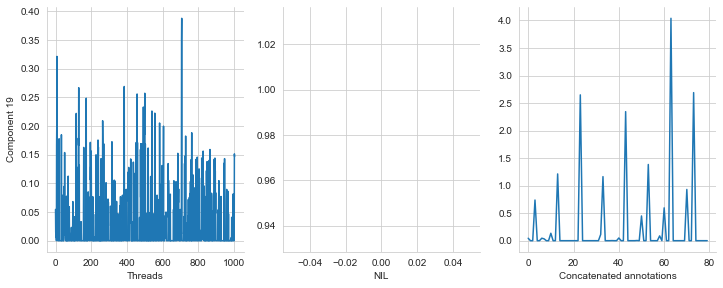

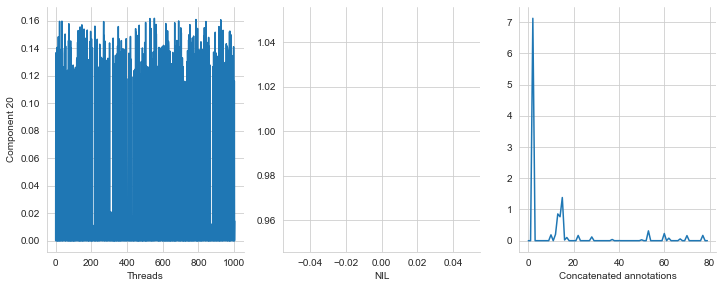

In [41]:
td_concat.summarize(corpus, axis_names=['Threads', 'NIL', 'Concatenated annotations'], 
             output_dir='convokit/tensor_decomposer/reports/coarse-discourse', 
             report_title='Coarse discourse', 
             liwc=True)

In [42]:
td_concat.factors[2].shape

(80, 20)

In [43]:
feat_df = pd.DataFrame(td_concat.factors[2].T)
std_scaled_df = std_scale_df(feat_df)

In [44]:
pd.set_option('display.max_columns', 500)
std_scaled_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
1,-0.372604,-0.382385,-0.382385,-0.249246,-0.382385,-0.382385,0.734680,-0.218351,-0.382385,-0.382385,-0.382385,-0.382385,-0.382385,-0.382385,-0.382385,-0.382385,1.813907,-0.162201,-0.056625,-0.221754,-0.382385,-0.382385,-0.382385,-0.382385,-0.382385,-0.382385,2.590015,0.217579,-0.334945,-0.155996,-0.382385,-0.382385,-0.382385,-0.382385,-0.382385,-0.382385,3.180153,-0.100756,-0.382385,-0.197394,-0.382385,-0.382385,-0.382385,-0.382385,-0.382385,-0.382385,3.181349,0.187445,-0.382385,-0.290488,-0.382385,-0.382385,-0.382385,-0.382385,-0.367927,-0.382385,3.631534,0.192862,-0.382385,-0.195373,-0.382385,-0.382385,-0.382385,-0.382385,-0.382385,-0.382385,3.612316,0.181693,-0.282153,-0.201801,-0.382385,-0.382385,-0.382385,-0.371678,-0.382385,-0.382385,3.788202,-0.030832,-0.382385,-0.382385
2,-0.186993,-0.186993,-0.186993,-0.186993,-0.174337,-0.186993,-0.186993,-0.098480,-0.186993,-0.092599,-0.186993,-0.186993,-0.186993,-0.186993,-0.113115,-0.186993,-0.186993,-0.186993,-0.127116,-0.186993,-0.186993,-0.186993,-0.186993,0.287295,-0.186993,-0.186993,-0.186993,-0.001118,-0.186993,-0.186993,-0.186993,-0.186993,-0.172262,-0.186993,-0.082920,-0.186993,-0.186993,-0.022011,-0.162938,-0.186993,-0.186993,-0.186993,-0.186993,0.014089,-0.186993,-0.186993,-0.186993,-0.147892,-0.186993,-0.186993,-0.186993,-0.186993,-0.037709,-0.182301,-0.124243,-0.186993,-0.186993,-0.053383,-0.158545,0.024720,-0.186993,-0.186993,-0.186993,-0.186993,-0.186993,-0.186993,-0.186993,-0.186993,-0.186993,6.114327,-0.186993,-0.186993,6.342532,-0.186993,-0.186993,-0.186408,-0.186993,-0.186993,-0.186993,-0.186993
3,-0.265061,8.194903,-0.265061,-0.265061,-0.265061,-0.265061,-0.265061,-0.265061,1.141424,0.422189,-0.124677,-0.265061,-0.265061,1.402736,-0.005531,1.374006,-0.265061,1.431927,-0.102057,-0.018600,-0.265061,-0.265061,-0.265061,-0.265061,0.040495,-0.265061,-0.142857,0.672599,-0.265061,-0.265061,-0.265061,-0.265061,-0.265061,-0.068179,-0.265061,-0.265061,-0.265061,-0.120866,-0.265061,-0.265061,-0.265061,-0.265061,-0.265061,-0.265061,-0.265061,-0.221821,-0.265061,0.111964,-0.265061,-0.265061,-0.265061,-0.265061,-0.265061,-0.265061,-0.265061,-0.265061,-0.265061,0.459484,-0.265061,-0.252503,-0.265061,-0.265061,-0.265061,-0.265061,-0.265061,-0.265061,-0.265061,0.426926,-0.265061,-0.262161,-0.265061,-0.265061,-0.265061,0.196202,-0.265061,-0.265061,-0.265061,0.552882,-0.265061,-0.265061
4,-0.342046,-0.342046,-0.342046,-0.342046,-0.342046,-0.342046,-0.338342,-0.288740,1.451414,-0.304100,-0.331204,-0.342046,-0.342046,-0.342046,-0.342046,-0.342046,-0.279579,-0.342046,2.013455,-0.322135,-0.254924,-0.342046,-0.342046,-0.342046,-0.342046,-0.342046,-0.342046,-0.327107,2.743331,-0.342046,-0.342046,-0.342046,-0.342046,-0.342046,-0.342046,-0.342046,-0.342046,-0.177011,3.338865,-0.314307,-0.342046,-0.342046,-0.342046,-0.342046,-0.342046,-0.322673,-0.238833,-0.108049,3.110490,-0.342046,-0.342046,-0.342046,-0.342046,-0.038684,-0.342046,-0.342046,-0.319600,-0.342046,3.401488,-0.314470,-0.342046,-0.342046,-0.342046,-0.342046,-0.342046,-0.342046,-0.342046,-0.342046,3.585392,-0.267400,-0.342046,-0.342046,-0.342046,-0.279022,-0.342046,-0.342046,-0.342046,-0.342046,3.652216,-0.342046
5,-0.186337,-0.186337,-0.186337,-0.146801,-0.186337,-0.186337,-0.177350,-0.186337,-0.186337,-0.186337,-0.186337,-0.186337,-0.186337,-0.186337,-0.186337,-0.186337,-0.186337,-0.186337,-0.186337,-0.186337,-0.186337,-0.186337,-0.132174,-0.186337,-0.022081,-0.186337,-0.139350,-0.186337,-0.164725,-0.186337,-0.186337,-0.186337,-0.186337,-0.049999,-0.186337,-0.186337,-0.186337,-0.186337,-0.186337,-0.186337,-0.186337,-0.186337,-0.001671,-0.183766,-0.133314,-0.002820,-0.186337,-0.186337,-0.091733,0.048359,-0.186337,-0.186337,-0.186337,-0.186337,-0.186337,-0.186337,-0.186337,-0.186337,-0.186337,6.183906

In [45]:
def get_component_decomposition_nonnegative(V):
    feat_df = pd.DataFrame(V, index=list(range(1, V.shape[0]+1)), columns=list(range(1, V.shape[1]+1))).T
    retval = dict()
    for i in range(feat_df.shape[0]):
        s = sorted(list(feat_df.iloc[i].items()), key=lambda x: x[1], reverse=True)
        pos = [x[0] for x in s if x[1] >= 1]
        retval[i+1] = {'pos': pos}
    return retval

In [46]:
decomposed = get_component_decomposition_nonnegative(std_scaled_df.T)

In [47]:
decomposed

{1: {'pos': [76, 56, 66, 46, 36, 26, 16]},
 2: {'pos': [72, 69]},
 3: {'pos': [1, 17, 13, 15, 8]},
 4: {'pos': [78, 68, 58, 38, 48, 28, 18, 8]},
 5: {'pos': [62, 59]},
 6: {'pos': [55, 45]},
 7: {'pos': [39, 42]},
 8: {'pos': [35, 45]},
 9: {'pos': [25, 15, 5]},
 10: {'pos': [65]},
 11: {'pos': [49, 52, 35]},
 12: {'pos': [20, 30, 40, 60, 50, 70]},
 13: {'pos': [79]},
 14: {'pos': [32, 29]},
 15: {'pos': [19, 22]},
 16: {'pos': [54, 44, 64, 34, 74, 24, 14]},
 17: {'pos': [75]},
 18: {'pos': [9, 12, 25]},
 19: {'pos': [63, 73, 23, 43, 53, 13, 33, 70]},
 20: {'pos': [2, 15]}}

In [48]:
from collections import defaultdict
def index_to_semantic(ls):
    retval = defaultdict(list)
    for idx in ls:
        comment_idx = idx // 10 + 1
        retval[idx_to_annot[idx % 10]].append(comment_idx)
    for k, v in retval.items():
        retval[k] = sorted(v)
    return retval

In [49]:
idx_to_annot = {idx: v for idx, v in enumerate(annotation_types)}

In [50]:
for component_idx in range(1, len(decomposed)+1):
    print("Component index: {}\n".format(component_idx))
    print("Positive:")
    print(dict(index_to_semantic(decomposed[component_idx]['pos'])))
    print("------------------------------\n")

Component index: 1

Positive:
{'humor': [2, 3, 4, 5, 6, 7, 8]}
------------------------------

Component index: 2

Positive:
{'answer': [8], 'question': [7]}
------------------------------

Component index: 3

Positive:
{'announcement': [1], 'negativereaction': [2], 'appreciation': [2], 'elaboration': [2], 'other': [1]}
------------------------------

Component index: 4

Positive:
{'other': [1, 2, 3, 4, 5, 6, 7, 8]}
------------------------------

Component index: 5

Positive:
{'answer': [7], 'question': [6]}
------------------------------

Component index: 6

Positive:
{'elaboration': [5, 6]}
------------------------------

Component index: 7

Positive:
{'question': [4], 'answer': [5]}
------------------------------

Component index: 8

Positive:
{'elaboration': [4, 5]}
------------------------------

Component index: 9

Positive:
{'elaboration': [1, 2, 3]}
------------------------------

Component index: 10

Positive:
{'elaboration': [7]}
------------------------------

Component ind

### Concrete example

In [51]:
td_concat.factors[0][361]

array([0.        , 0.15261169, 0.        , 0.        , 0.04740898,
       0.00756761, 0.17535472, 0.04683425, 0.        , 0.        ,
       0.05176481, 0.        , 0.        , 0.13814082, 0.        ,
       0.        , 0.        , 0.10639059, 0.        , 0.        ])

In [52]:
np.array(std_scale_df(pd.DataFrame(td_concat.factors[0]).T).T.iloc[361])

array([-0.31311061,  1.74638578, -0.51810473, -0.40436062,  0.51591378,
       -0.86525242,  1.75136234, -0.28058032, -0.99543085, -0.97656642,
        0.27085628, -0.59587997, -0.55226929,  1.71133917, -0.63582787,
       -0.65497927, -1.01963152,  1.03832526, -0.59055477, -0.61259389])

## Comparison: An SVD analysis

In [53]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

In [54]:
for convo in corpus.iter_conversations():
    utts = convo.get_chronological_utterance_list()
    for utt_idx in range(len(utts) - LENGTH):
        subset = utts[utt_idx: utt_idx + LENGTH]
        start_utt = utts[utt_idx]
        for idx, utt in enumerate(subset):
            start_utt.meta['annot-dict-{}'.format(idx+1)] = utt.meta['annot-dict']
        start_utt.meta['valid'] = True

In [55]:
for convo in corpus.iter_conversations():
    utts = convo.get_chronological_utterance_list()
    for utt_idx in range(len(utts) - LENGTH):
        subset = utts[utt_idx: utt_idx + LENGTH]
        start_utt = utts[utt_idx]
        start_utt.meta['concat'] = dict()
        for idx, utt in enumerate(subset):
            d = start_utt.meta['annot-dict-{}'.format(idx+1)].copy()
            start_utt.meta['concat'].update({k+"_"+str(idx): v for k, v in d.items()})

In [56]:
concat_vals = []
for utt in corpus.iter_utterances(lambda u: u.meta['valid']):
    concat_vals.append(list(utt.meta['concat'].values()))

In [57]:
svd = TruncatedSVD(n_components=20, random_state=42)
svd.fit(concat_vals)

TruncatedSVD(algorithm='randomized', n_components=20, n_iter=5, random_state=42,
             tol=0.0)

In [58]:
U, s, V = svd.transform(concat_vals) / svd.singular_values_, \
        svd.singular_values_, \
        svd.components_.T

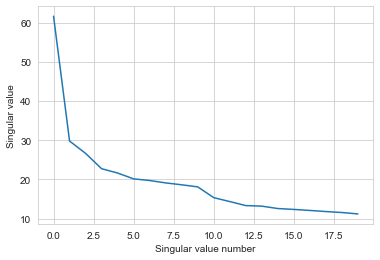

In [59]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(s)
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [60]:
feat_df = pd.DataFrame(V.T)
std_scaled_df = std_scale_df(feat_df)

In [61]:
def get_component_decomposition(V):
    feat_df = pd.DataFrame(V, index=list(range(1, V.shape[0]+1)), columns=list(range(1, V.shape[1]+1))).T
    retval = dict()
    for i in range(feat_df.shape[0]):
        s = sorted(list(feat_df.iloc[i].items()), key=lambda x: x[1], reverse=True)
        neg = [x[0] for x in s if x[1] <= -1]
        pos = [x[0] for x in s if x[1] >= 1]
        retval[i+1] = {'neg': neg, 'pos': pos}
    return retval

In [62]:
decomposed = get_component_decomposition(std_scaled_df.T)

In [63]:
V.shape

(80, 20)

###########
1


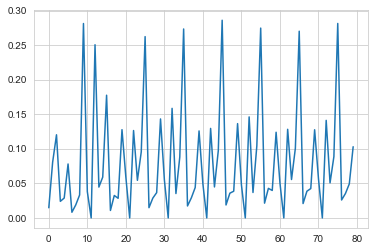

###########
2


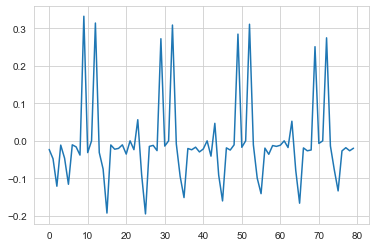

###########
3


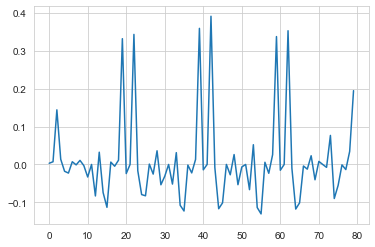

###########
4


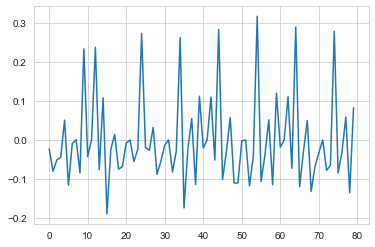

###########
5


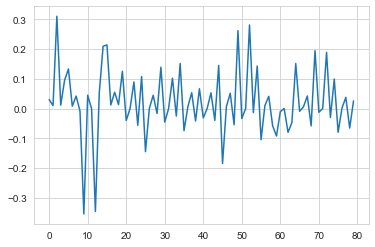

###########
6


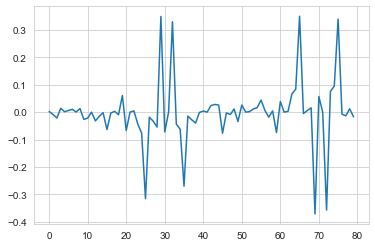

###########
7


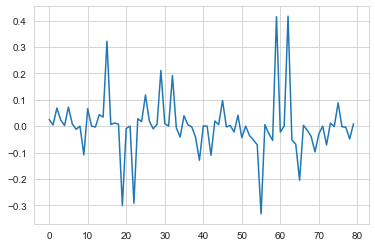

###########
8


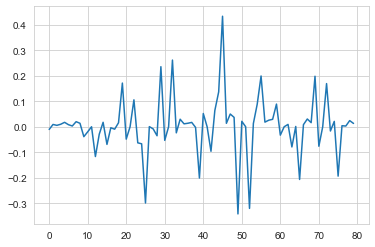

###########
9


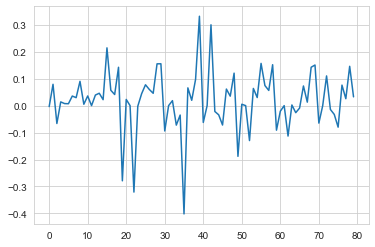

###########
10


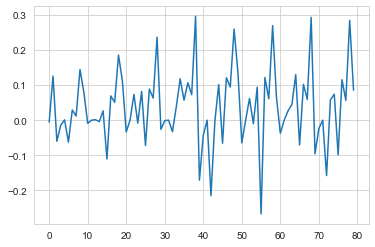

###########
11


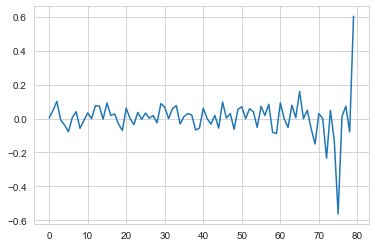

###########
12


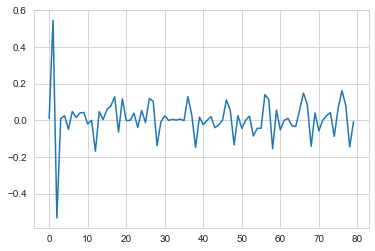

###########
13


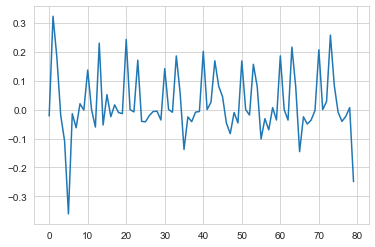

###########
14


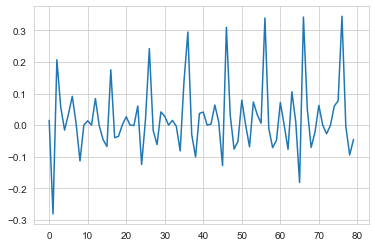

###########
15


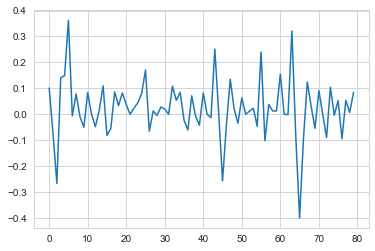

###########
16


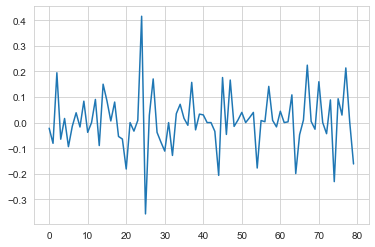

###########
17


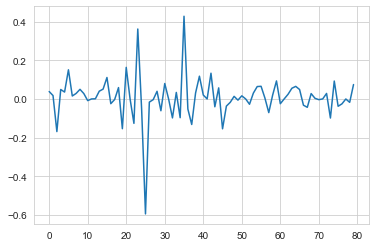

###########
18


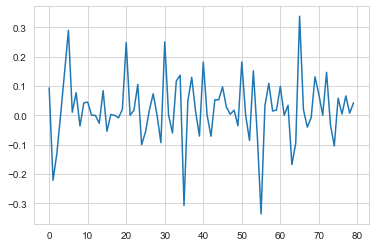

###########
19


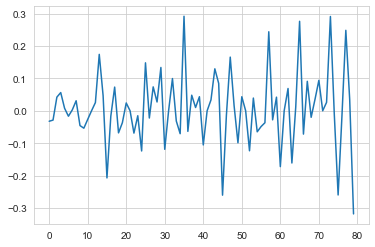

###########
20


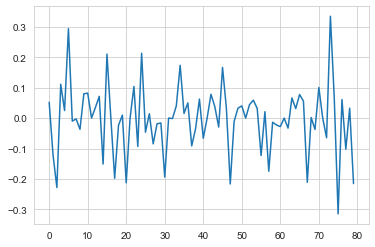

In [64]:
for component_idx in range(V.shape[1]):
    print('###########')
    print(component_idx + 1)
    sns.lineplot(data=V.T[component_idx])
    plt.show()

In [65]:
for component_idx in range(1, V.shape[1]+1):
    print("Component index: {}\n".format(component_idx))
    print("Positive:")
    print(dict(index_to_semantic(decomposed[component_idx]['pos'])))
    print("Negative:")
    print(dict(index_to_semantic(decomposed[component_idx]['neg'])))
    print("------------------------------\n")

Component index: 1

Positive:
{'elaboration': [2, 3, 4, 5, 6, 7, 8], 'question': [1], 'answer': [2, 4]}
Negative:
{'announcement': [2, 3, 4, 5, 6, 7, 8]}
------------------------------

Component index: 2

Positive:
{'question': [1, 3, 5, 7], 'answer': [2, 4, 6, 8]}
Negative:
{'answer': [1], 'elaboration': [2, 3, 4, 5, 6, 7, 8]}
------------------------------

Component index: 3

Positive:
{'answer': [1, 3, 5, 7], 'question': [2, 4, 6, 8]}
Negative:
{'disagreement': [4, 5, 6, 7], 'elaboration': [2, 4, 6]}
------------------------------

Component index: 4

Positive:
{'disagreement': [3, 4, 5, 6, 7, 8], 'answer': [2, 7], 'question': [1, 4, 6]}
Negative:
{'other': [4, 6, 7, 8], 'elaboration': [1, 2, 4, 7], 'answer': [6]}
------------------------------

Component index: 5

Positive:
{'answer': [1, 6, 8], 'question': [3, 5, 7], 'elaboration': [1, 2], 'disagreement': [2, 4, 5, 6, 7]}
Negative:
{'question': [1, 6], 'elaboration': [3, 5, 6], 'answer': [2]}
------------------------------

Comp

### Thread analysis

In [66]:
U[361]

array([ 3.10578058e-02,  6.11049174e-02,  2.55381014e-02,  1.36947694e-02,
        2.17171481e-03, -1.16949943e-02,  1.80738381e-02,  3.20587344e-02,
        4.39018532e-02, -3.07249357e-02, -1.24847317e-02,  3.63611383e-03,
       -5.45788457e-03, -8.62507006e-03, -3.12963809e-02,  9.04546391e-03,
        5.12400819e-03,  4.26635355e-03,  9.89453302e-05,  2.88718764e-02])

In [67]:
np.array(std_scale_df(pd.DataFrame(U).T).T.iloc[361])

array([ 5.20245538e-02,  1.90492500e+00,  7.27175879e-01,  4.34407469e-01,
       -1.08296380e-02, -3.57119686e-01,  5.47871335e-01,  1.01573339e+00,
        1.35344702e+00, -1.04277504e+00, -4.19090905e-01,  9.66091341e-02,
       -2.01102944e-01, -3.17624918e-01, -1.02293690e+00,  2.78819972e-01,
        1.53350323e-01,  1.09402151e-01, -4.58466990e-05,  9.08681101e-01])

### TSNE

In [75]:
from sklearn.manifold import TSNE
import plotly.express as px


In [76]:
tsne_TCA = TSNE(n_components=2, random_state=234)
flattened = tsne_TCA.fit_transform(td.factor2_matrix.matrix)

In [89]:
TCA_df = pd.DataFrame(flattened, columns=['x', 'y'])
utt_ids = [utt.id for utt in corpus.iter_utterances(min_length)]
TCA_df['utt_ids'] = utt_ids

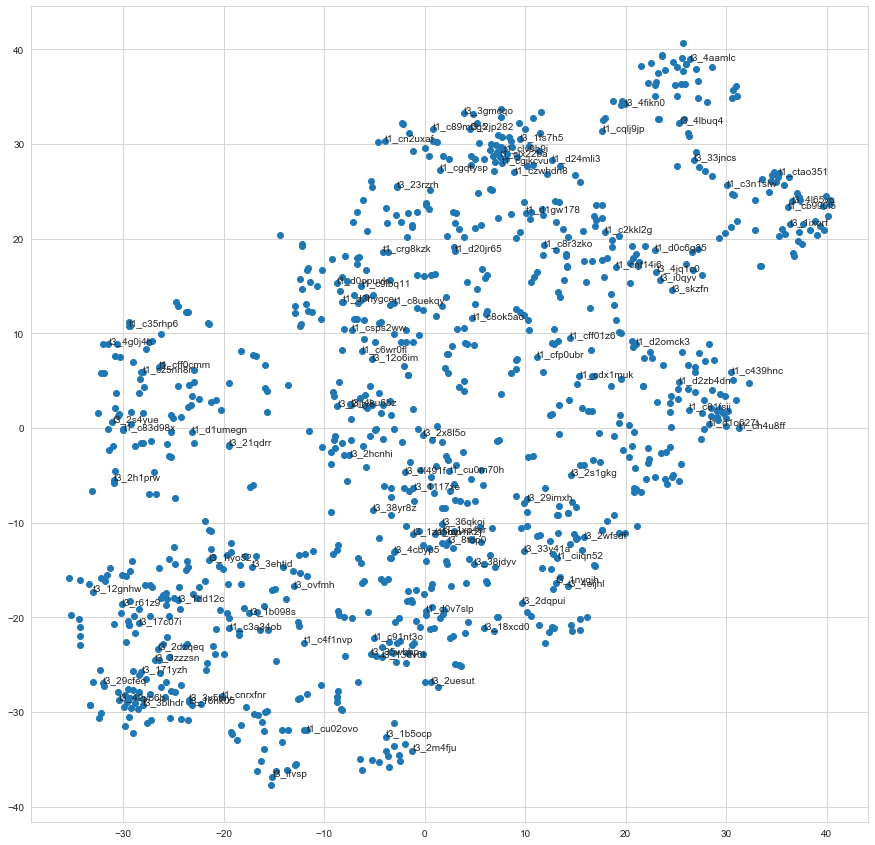

In [96]:
plt.figure(figsize=(15,15))
plt.scatter(TCA_df['x'].values, TCA_df['y'].values)
for i, convo_id in enumerate(TCA_df.index):
    if random.random() < 0.1:
        plt.annotate(utt_ids[i], (TCA_df.iloc[i]['x'], TCA_df.iloc[i]['y']))
plt.show()

In [137]:
# Bottom left corner
corpus.get_utterance('t1_cb990l5').get_conversation().print_conversation_structure(lambda utt: 
                                                                                   str(utt.meta['annotation-types']))

['announcement', 'question', 'other']
    ['other', 'answer', 'other']
        ['humor', 'humor', 'other']
            ['appreciation', 'appreciation', 'other']
                ['question', 'elaboration', 'other']
                    ['humor', 'question', 'other']
                        ['negativereaction', 'answer', 'other']
                            ['elaboration', 'elaboration', 'other']
                                ['elaboration', 'elaboration', 'other']
                                    ['question', 'question', 'other']
                                        ['answer', 'answer', 'other']


In [134]:
for utt in corpus.iter_utterances(min_length):
    if utt.id.startswith('t1_cb9'):
        print(utt.id)

t1_cb98qih
t1_cb990l5
t1_cb9bxne
t1_cb9c2j6


In [131]:
corpus.get_conversation('t3_36qkoj').print_conversation_structure(lambda utt: 
                                                                  str(utt.meta['annotation-types']), limit=8)

['question', 'question', 'question']
    ['answer', 'answer', 'answer']
        ['elaboration', 'elaboration', 'elaboration']
            ['disagreement', 'disagreement', 'disagreement']
                ['elaboration', 'elaboration', 'elaboration']
                    ['agreement', 'agreement', 'agreement']
                        ['elaboration', 'disagreement', 'elaboration']
                            ['elaboration', 'elaboration', 'elaboration']


In [153]:
for utt in corpus.iter_utterances(min_length):
    convo = utt.get_conversation()
    path = []
    ctr = 0
    started = False
    for utt_ in convo.iter_utterances():
        if started and ctr < 8:
            path.append(utt_.meta['annotation-types'])
            ctr += 1
        elif utt_.id == utt.id:
            started = True
            path.append(utt_.meta['annotation-types'])
            ctr += 1
        elif ctr > 8:
            break
    utt.meta['path'] = path

In [161]:
for utt in corpus.iter_utterances(min_length):
    utt.meta['pretty-path'] = '\n '.join(str(x) for x in utt.meta['path'])

In [174]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

kmeans = KMeans(n_clusters=15)
kmeans.fit(td.factor2_matrix.matrix)

knn = NearestNeighbors(n_neighbors=6)
knn.fit(td.factor2_matrix.matrix)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                 radius=1.0)

In [175]:
utts = list(corpus.iter_utterances(min_length))

In [176]:
for idx, cluster_pt in enumerate(kmeans.cluster_centers_, start=1):
    print(f"Cluster {idx}")
    for i in knn.kneighbors([cluster_pt], return_distance=False)[0]:
        print(utts[i].meta['pretty-path'], end=" ")
        print('\n')
    print()

Cluster 1
['question', 'question', 'question']
 ['answer', 'answer', 'answer']
 ['agreement', 'elaboration', 'agreement']
 ['disagreement', 'elaboration', 'elaboration']
 ['appreciation', 'appreciation', 'appreciation']
 ['elaboration', 'elaboration', 'agreement']
 ['agreement', 'agreement', 'agreement']
 ['elaboration', 'elaboration', 'elaboration'] 

['question', 'question', 'question']
 ['answer', 'answer', 'answer']
 ['elaboration', 'disagreement', 'elaboration']
 ['elaboration', 'elaboration', 'elaboration']
 ['elaboration', 'disagreement', 'elaboration']
 ['elaboration', 'elaboration', 'elaboration']
 ['elaboration', 'elaboration', 'elaboration']
 ['elaboration', 'elaboration', 'elaboration'] 

['question', 'question', 'question']
 ['answer', 'answer', 'answer']
 ['answer', 'elaboration', 'disagreement']
 ['elaboration', 'elaboration', 'elaboration']
 ['elaboration', 'elaboration', 'elaboration']
 ['elaboration', 'elaboration', 'elaboration']
 ['elaboration', 'elaboration', 'elab

### TCA-concat TSNE

In [146]:
tsne_TCA_concat = TSNE(n_components=2, random_state=234)
TCA_concat_df = pd.DataFrame(tsne_TCA_concat.fit_transform(td_concat.factor1_matrix.matrix), columns=['x', 'y'])
utt_ids = [utt.id for utt in corpus.iter_utterances(min_length)]
TCA_concat_df['utt_ids'] = utt_ids

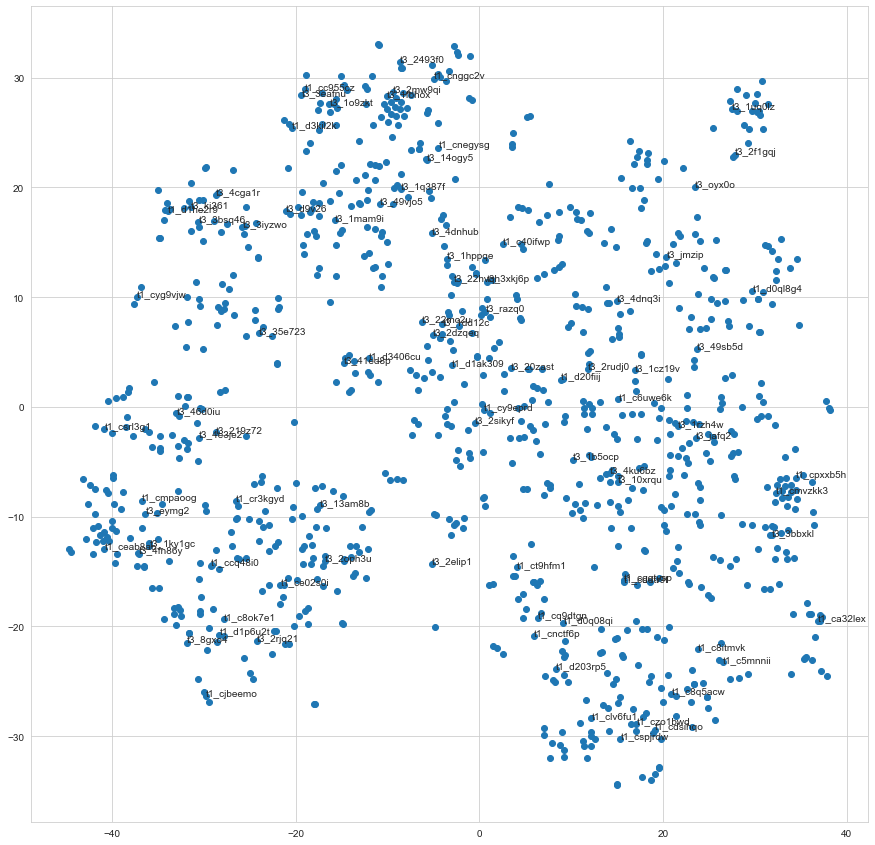

In [147]:
plt.figure(figsize=(15,15))
plt.scatter(TCA_concat_df['x'].values, TCA_concat_df['y'].values)
for i, convo_id in enumerate(TCA_concat_df.index):
    if random.random() < 0.1:
        plt.annotate(utt_ids[i], (TCA_concat_df.iloc[i]['x'], TCA_concat_df.iloc[i]['y']))
plt.show()

In [74]:
td.factor2_matrix.matrix

array([[0.        , 0.        , 0.00588075, ..., 0.        , 0.        ,
        0.1258959 ],
       [0.15651176, 0.        , 0.        , ..., 0.09506016, 0.09358666,
        0.        ],
       [0.00040769, 0.        , 0.        , ..., 0.06479043, 0.15994678,
        0.11566357],
       ...,
       [0.17578882, 0.04416512, 0.11615592, ..., 0.        , 0.14084268,
        0.00461927],
       [0.        , 0.        , 0.00718937, ..., 0.00282521, 0.06590147,
        0.        ],
       [0.        , 0.        , 0.00692495, ..., 0.        , 0.08213361,
        0.00082251]])

In [178]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

kmeans = KMeans(n_clusters=15)
kmeans.fit(td_concat.factor1_matrix.matrix)

knn = NearestNeighbors(n_neighbors=6)
knn.fit(td_concat.factor1_matrix.matrix)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                 radius=1.0)

In [179]:
for idx, cluster_pt in enumerate(kmeans.cluster_centers_, start=1):
    print(f"Cluster {idx}")
    for i in knn.kneighbors([cluster_pt], return_distance=False)[0]:
        print(utts[i].meta['pretty-path'], end=" ")
        print('\n')
    print()

Cluster 1
['announcement', 'announcement', 'announcement']
 ['other', 'elaboration', 'elaboration']
 ['other', 'elaboration', 'elaboration']
 ['other', 'elaboration', 'elaboration']
 ['other', 'elaboration', 'elaboration']
 ['other', 'elaboration', 'elaboration']
 ['other', 'elaboration', 'elaboration']
 ['other', 'elaboration', 'elaboration'] 

['question', 'question', 'question']
 ['answer', 'answer', 'answer']
 ['elaboration', 'agreement', 'agreement']
 ['elaboration', 'other']
 ['elaboration', 'other']
 ['elaboration', 'elaboration']
 ['elaboration', 'other']
 ['elaboration', 'other'] 

['elaboration', 'other']
 ['elaboration', 'other']
 ['elaboration', 'other']
 ['elaboration', 'other']
 ['elaboration', 'other']
 ['elaboration', 'other']
 ['elaboration', 'other']
 ['elaboration', 'other'] 

['other', 'elaboration', 'elaboration']
 ['other', 'elaboration', 'elaboration']
 ['other', 'elaboration', 'elaboration']
 ['other', 'elaboration', 'elaboration']
 ['other', 'elaboration', 'ela

### TSNE SVD concat

In [141]:
tsne_SVD_concat = TSNE(n_components=2, random_state=234)
SVD_concat_df = pd.DataFrame(tsne_TCA_concat.fit_transform(U), columns=['x', 'y'])
utt_ids = [utt.id for utt in corpus.iter_utterances(min_length)]
SVD_concat_df['utt_ids'] = utt_ids

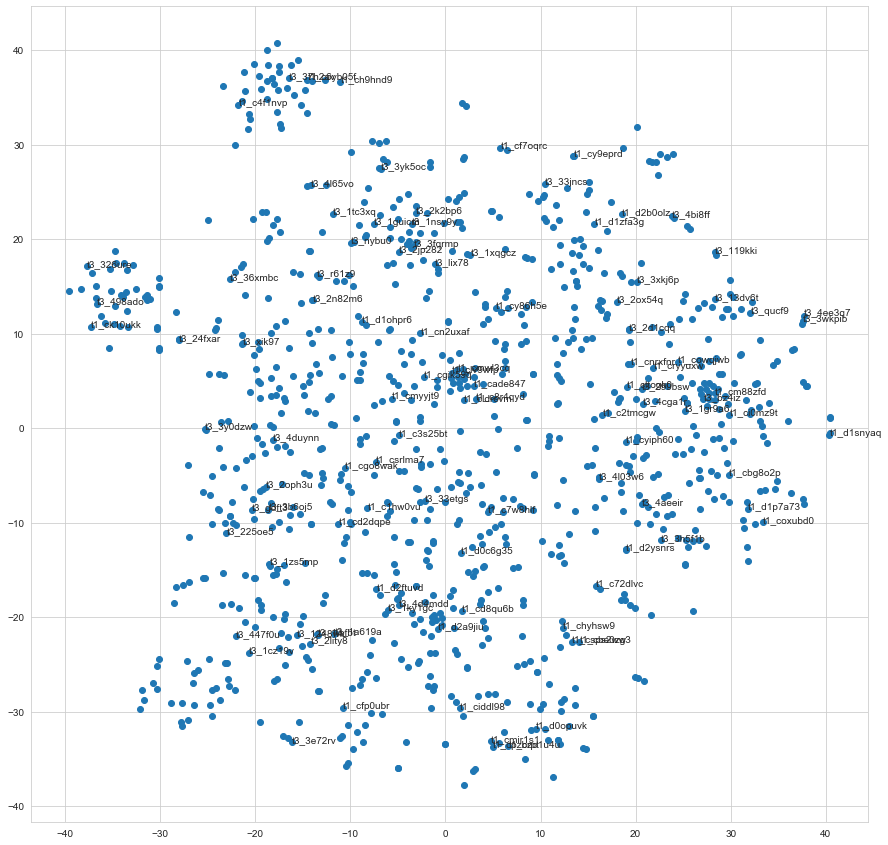

In [142]:
plt.figure(figsize=(15,15))
plt.scatter(SVD_concat_df['x'].values, SVD_concat_df['y'].values)
for i, convo_id in enumerate(SVD_concat_df.index):
    if random.random() < 0.1:
        plt.annotate(utt_ids[i], (SVD_concat_df.iloc[i]['x'], SVD_concat_df.iloc[i]['y']))
plt.show()

In [180]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

kmeans = KMeans(n_clusters=15)
kmeans.fit(U)

knn = NearestNeighbors(n_neighbors=6)
knn.fit(U)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                 radius=1.0)

In [181]:
for idx, cluster_pt in enumerate(kmeans.cluster_centers_, start=1):
    print(f"Cluster {idx}")
    for i in knn.kneighbors([cluster_pt], return_distance=False)[0]:
        print(utts[i].meta['pretty-path'], end=" ")
        print('\n')
    print()

Cluster 1
['announcement', 'announcement', 'announcement']
 ['question', 'elaboration', 'answer']
 ['elaboration', 'appreciation', 'elaboration']
 ['elaboration', 'elaboration', 'elaboration']
 ['elaboration', 'elaboration', 'elaboration']
 ['elaboration', 'elaboration', 'elaboration']
 ['agreement', 'elaboration', 'elaboration']
 ['appreciation', 'elaboration', 'elaboration'] 

['announcement', 'announcement', 'announcement']
 ['elaboration', 'other', 'elaboration']
 ['answer', 'elaboration', 'elaboration']
 ['elaboration', 'elaboration', 'elaboration']
 ['elaboration', 'other', 'elaboration']
 ['elaboration', 'elaboration', 'elaboration']
 ['elaboration', 'elaboration', 'elaboration']
 ['elaboration', 'elaboration', 'elaboration'] 

['announcement', 'announcement', 'question']
 ['elaboration', 'elaboration', 'elaboration']
 ['elaboration', 'elaboration', 'elaboration']
 ['elaboration', 'elaboration', 'elaboration']
 ['elaboration', 'elaboration', 'elaboration']
 ['elaboration', 'elab

In [68]:
concat_vals = np.array(concat_vals)

In [69]:
for convo in corpus.iter_conversations():
    
    convo.meta['concat'] = dict()
    for idx in range(1, 6+1):
        d = convo.meta['annot-dict-{}'.format(idx)].copy()
        convo.meta['concat'].update({k+"_"+str(idx): v for k, v in d.items()})

KeyError: 'annot-dict-1'

In [ ]:
u, s, vh = np.linalg.svd(a, full_matrices=True)

In [ ]:
components = td.get_components(corpus, selector=lambda convo: convo.meta['longest_path'] >= 8)

In [ ]:
td.thread_anomaly_threshold = 1.5

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

In [ ]:
td.get_component_example(components, 1)

In [ ]:
components[7]['pos_feats']

In [ ]:
td.get_component_example(components, 8)

In [ ]:
td.get_component_example(components, 7)

In [ ]:
corpus.get_conversation('t3_29dtve').get_utterances_dataframe()[['text', 'speaker', 'meta.majority_type']]

In [ ]:
td.get_component_example(components, 3)

In [ ]:
td.get_component_example(components, 2)

In [ ]:
corpus.get_utterance('t1_d15lqk1').meta

In [ ]:
td.get_component_example(components, 4)

In [ ]:
td.get_component_example(components, 9)

In [ ]:
corpus.get_utterance('t1_c5j5t6r').meta['majority_type']

In [ ]:
td.get_component_example(components, 9)

In [ ]:
corpus.get_utterance('t1_c6hjgqv').meta

In [ ]:
td.get_component_example(components, 9)

In [ ]:
corpus.get_utterance('t1_d2o7juz').meta

In [ ]:
from collections import Counter

In [ ]:
dis_8 = 0
for convo_id in convo_df[convo_df['meta.longest_path'] >= 11].index:
    convo = corpus.get_conversation(convo_id)
    if convo.get_chronological_utterance_list()[9].meta['disagreement'] == 1:
        dis_8 += 1

In [ ]:
dis_8

In [ ]:
annotation_types